# Initialization

> We need to make sure that our gradients do not explode or vanish. This should help us break down the apropriate initialization for each torch module.

In [1]:
# |default_exp init

In [2]:
# |export
import logging
from collections import Counter
from contextlib import contextmanager
from functools import singledispatch

import lightning as L
import matplotlib.pyplot as plt
import torch
from torch import nn

from slow_diffusion.fashionmnist import FashionMNISTDataModule
from slow_diffusion.model import PreactConvBlock
from slow_diffusion.training import get_tiny_unet_lightning

/home/jeremy/micromamba/envs/slow_diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# |hide
plt.style.use("ggplot")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [4]:
dm = FashionMNISTDataModule(bs=128)
dm.setup()

In [5]:
((x_t, t), ε) = next(iter(dm.train_dataloader()))
x_t.shape

torch.Size([128, 1, 32, 32])

Let's verify that the distribution remains normal after the transformation is applied.

In [6]:
@singledispatch
def kaiming(module):
    ...

In [7]:
@kaiming.register(PreactConvBlock)
def _(c):
    if isinstance(c.act, nn.ReLU):
        torch.nn.init.kaiming_normal_(c.conv.weight, a=0.0)
    elif isinstance(c.act, nn.SiLU):
        torch.nn.init.kaiming_normal_(c.conv.weight, a=0.1)
    else:
        raise ValueError
    if c.conv.bias is not None:
        torch.nn.init.constant_(c.conv.bias, 0)

In [8]:
conv_relu_default = PreactConvBlock(1, 1, act=nn.ReLU)
conv_relu = PreactConvBlock(1, 1, act=nn.ReLU)
conv_silu_default = PreactConvBlock(1, 1, act=nn.SiLU)
conv_silu = PreactConvBlock(1, 1, act=nn.SiLU)
for m in [conv_relu, conv_silu]:
    kaiming(m)

In [9]:
def plot(xb, args, modules: list[tuple[str, nn.Module]]):
    fig, axes = plt.subplots(1, len(modules), figsize=(4 * len(modules), 4))
    for ax, (label, c) in zip(axes, cs):
        _, bins, _ = ax.hist(xb.reshape(-1), bins=30, alpha=0.5, label="input")
        with torch.no_grad():
            yb = c(*args)
        ax.hist(yb.reshape(-1), bins, alpha=0.33, label=label)
        ax.set(xlabel="Logit magnitude", ylabel="Frequency", title=label)
    fig.tight_layout()

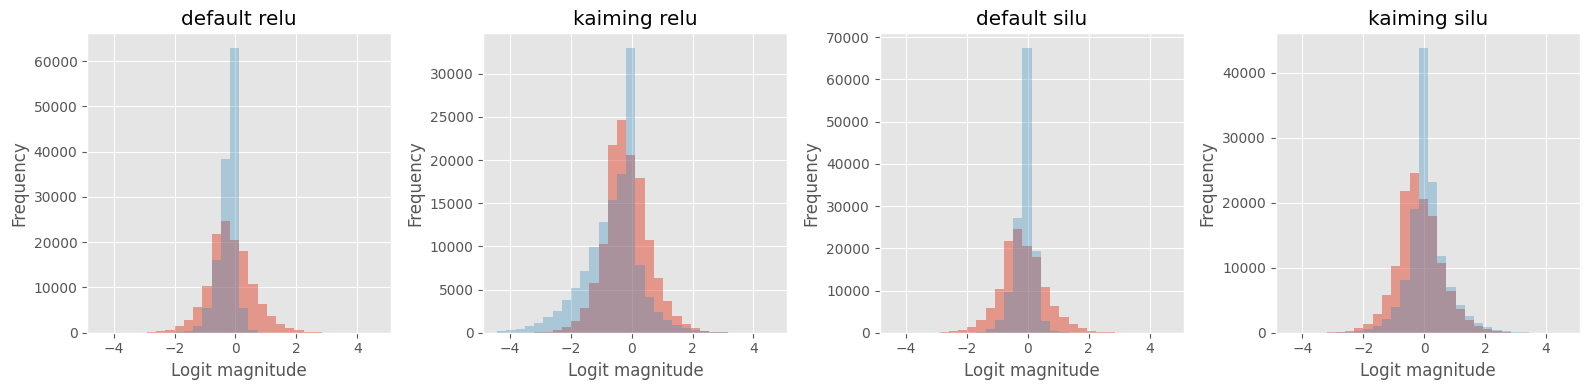

In [10]:
cs = [
    ("default relu", conv_relu_default),
    ("kaiming relu", conv_relu),
    ("default silu", conv_silu_default),
    ("kaiming silu", conv_silu),
]
plot(x_t, (x_t,), cs)

In [11]:
# |hide
for c in cs:
    del c

Good! The Kaiming methods preserve the distribution variance, unlike the default.

Let's start with initializing with Kaiming and see how we might need to adjust the ResBlocks.

In [12]:
def append(module, _, acts):
    module.acts = acts

In [13]:
@contextmanager
def monitor_activations(model):
    hooks = []
    for name, m in model.unet.named_modules():
        hooks.append(m.register_forward_hook(append))
    yield
    for hook in hooks:
        hook.remove()

In [14]:
model = get_tiny_unet_lightning(act=nn.ReLU)
model = model.apply(kaiming)

with monitor_activations(model), torch.no_grad():
    model.step(((x_t, t), ε))

In [15]:
color_map = {
    "Downblock": "b",
    "Upblock": "r",
    "Conv2d": "g",
    "ConvBlock": "purple",
    "Input": "orange",
    "PreactResBlock": "black",
    "NonPreactResBlock": "black",
}

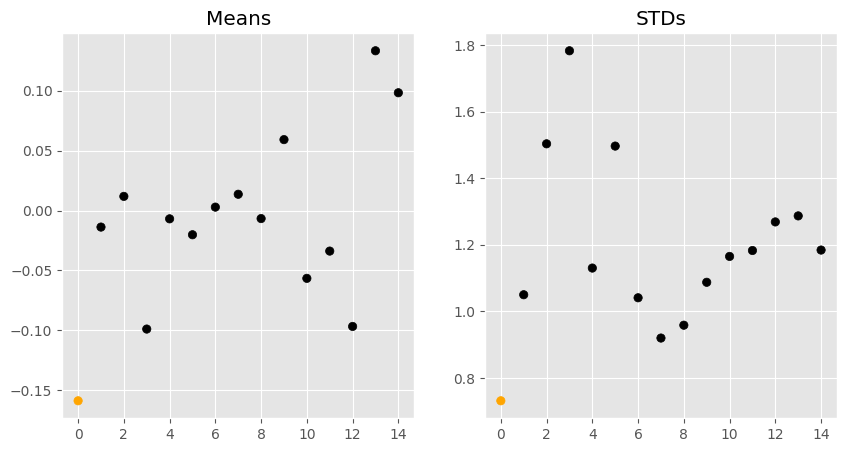

In [16]:
def plot_per_layer_stats(mods, name=None, axes=None):
    if axes is None:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    else:
        ax0, ax1 = axes
    if name:
        ax0.set(title=f"{name} means")
        ax1.set(title=f"{name} STDs")
    else:
        ax0.set(title="Means")
        ax1.set(title="STDs")

    data = []
    data.append((x_t.mean(), x_t.std(), "Input"))
    for m in mods:
        clsname = m.__class__.__name__
        row = (m.acts.mean(), m.acts.std(), clsname)
        data.append(row)
    means, stds, clss = zip(*data)
    idxs = torch.arange(0, len(data))
    colors = [color_map[c] for c in clss]
    ax0.scatter(idxs, means, c=colors)
    ax1.scatter(idxs, stds, c=colors)


def plot_per_resnet_stats(m):
    resnets = []
    for block in [*m.unet.downblocks, *m.unet.upblocks]:
        for conv in block.convs:
            resnets.append(conv)
    plot_per_layer_stats(resnets)


plot_per_resnet_stats(model)

Nothing suspicious after one iteration. Let's train it and see what happens.

In [17]:
def plot_per_layer_stats_after_training(
    model, max_steps=10, name=None, axes=None, **kwargs
):
    trainer = L.Trainer(
        max_epochs=1,
        precision="bf16-mixed",
        max_steps=max_steps,
        enable_progress_bar=False,
        enable_model_summary=False,
        **kwargs,
    )
    trainer.fit(model=model, datamodule=dm)
    with monitor_activations(model), torch.no_grad():
        model.step(((x_t, t), ε))
    resnets = []
    for block in [*model.unet.downblocks, *model.unet.upblocks]:
        for conv in block.convs:
            resnets.append(conv)
    plot_per_layer_stats(resnets, name, axes)
    return model

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
`Trainer.fit` stopped: `max_steps=50` reached.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
`Trainer.fit` stopped: `max_steps=50` reached.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
`Trainer.fit` stopped: `max_steps=50` reached.
Using bfloat16 Automatic Mixed Precision (A

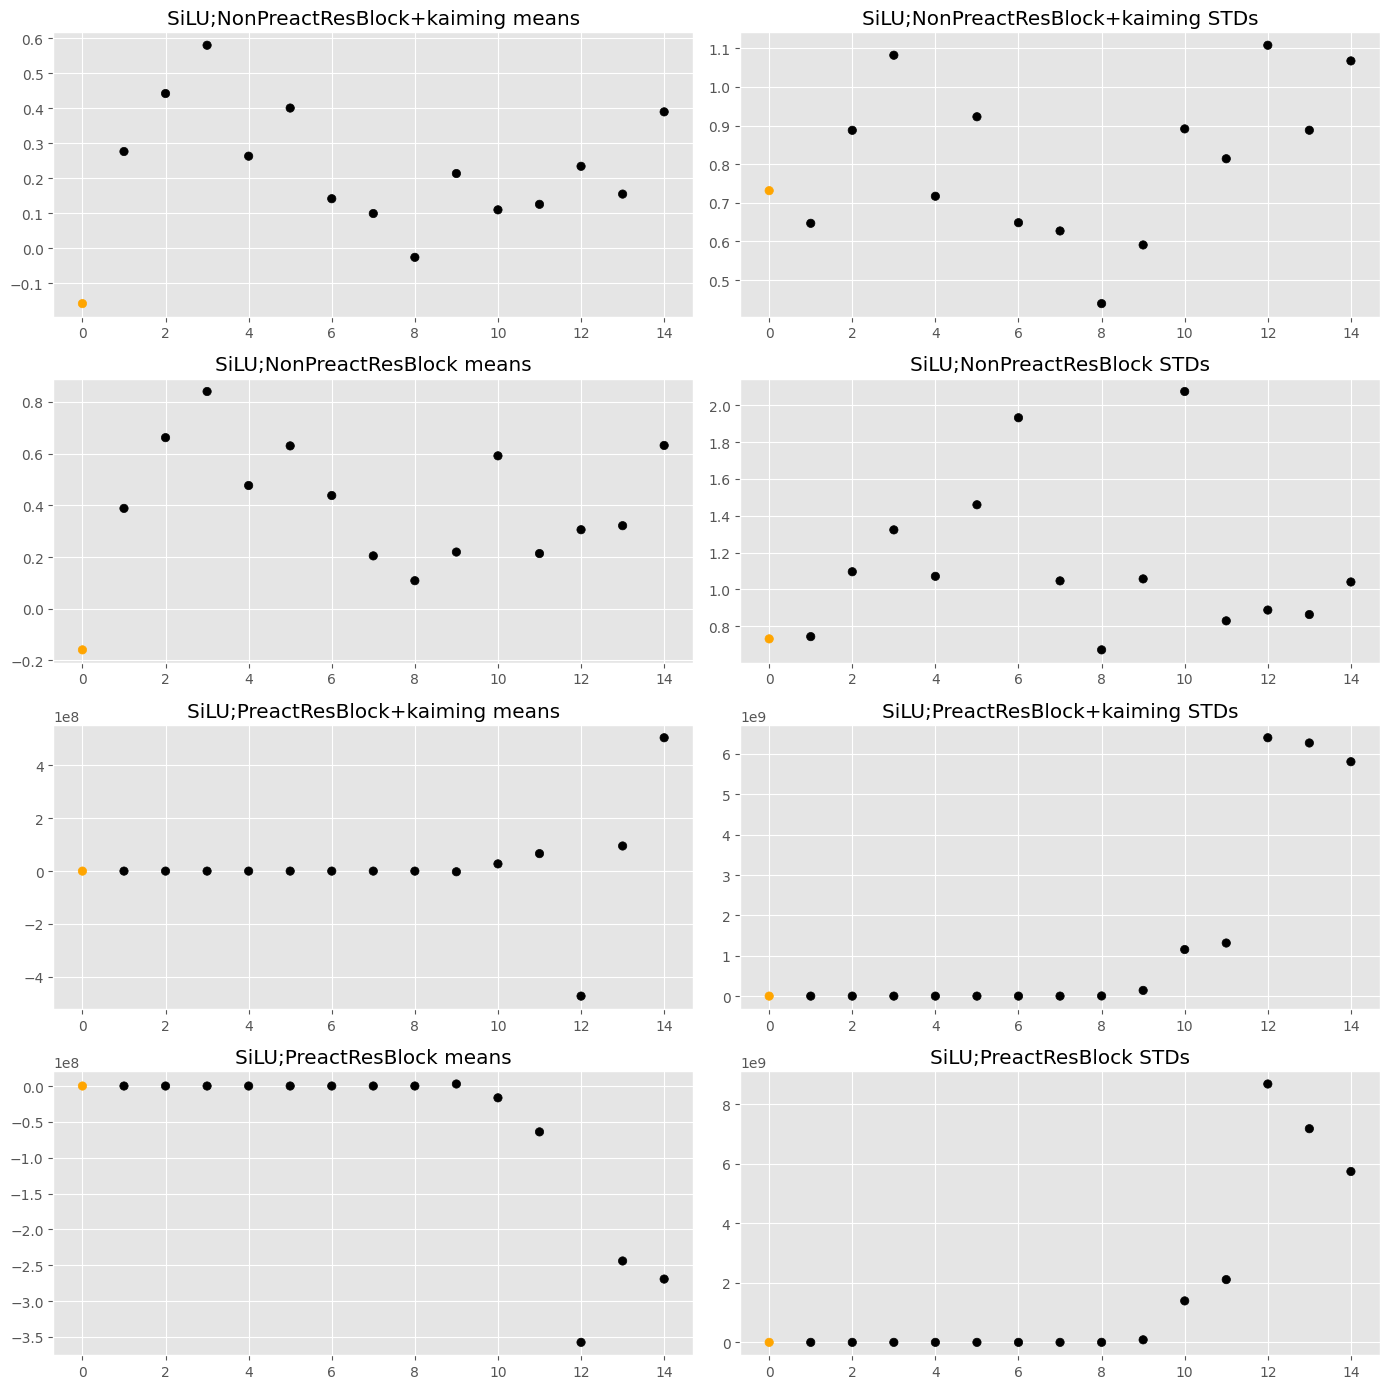

In [21]:
max_steps = 50
experiments = [
    # (nn.ReLU, True, "PreactResBlock"),
    # (nn.ReLU, False, "PreactResBlock"),
    (nn.SiLU, True, "NonPreactResBlock"),
    (nn.SiLU, False, "NonPreactResBlock"),
    (nn.SiLU, True, "PreactResBlock"),
    (nn.SiLU, False, "PreactResBlock"),
]
n = len(experiments)
k = 7
fig, axes = plt.subplots(n, 2, figsize=(2 * k, 0.5 * n * k))
for i, (act, kaiming_, res_block_cls) in enumerate(experiments):
    name = f"{act.__name__};{res_block_cls}"
    if kaiming_:
        name += "+kaiming"
    model = get_tiny_unet_lightning(act=act, res_block_cls=res_block_cls)
    if kaiming_:
        model.apply(kaiming)
    _ = plot_per_layer_stats_after_training(
        model, max_steps=max_steps, name=name, axes=axes[i, :]
    )
fig.tight_layout()

Nice! Looks like there's some issue with the pre-activation block. Let's use the classical configuration from now on.

In [20]:
# | hide
import nbdev

nbdev.nbdev_export()